In [1274]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [1275]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lectura de datos

In [1276]:
# DIR = "/content/drive/MyDrive/Data Mining Properati/"
#df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
#df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')

# df_test = pd.read_feather(DIR+'properati_a_predecir.ftr').set_index('id')
# df_train = pd.read_feather(DIR+'properati_entrenamiento.ftr').set_index('id')
# df_test.head()

# Entendimiento (magia parte 1 -- AID)

In [1277]:
df_test.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,None,...,2.0,NaN,NaN,NaN,USD,None,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta
192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,-58.430493,-34.606620,Argentina,Capital Federal,Almagro,None,...,2.0,77.0,67.0,NaN,USD,None,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta
238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,-58.491760,-34.574123,Argentina,Capital Federal,Villa Urquiza,None,...,1.0,60.0,55.0,NaN,USD,None,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,None,...,1.0,74.0,47.0,NaN,USD,None,PH Venta Boedo 2 amb Patio,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,None,...,1.0,66.0,64.0,NaN,USD,None,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta


In [1278]:
prueba = df_test.copy()

prueba.start_date = pd.to_datetime(prueba.start_date)

prueba.loc[prueba.end_date=='9999-12-31','end_date'] = np.nan

prueba.end_date = pd.to_datetime(prueba.end_date)
prueba.created_on = pd.to_datetime(prueba.created_on)

In [1279]:
train = df_train.copy()

train.start_date = pd.to_datetime(train.start_date)

train.loc[train.end_date=='9999-12-31','end_date'] = np.nan

train.end_date = pd.to_datetime(train.end_date)
train.created_on = pd.to_datetime(train.created_on)

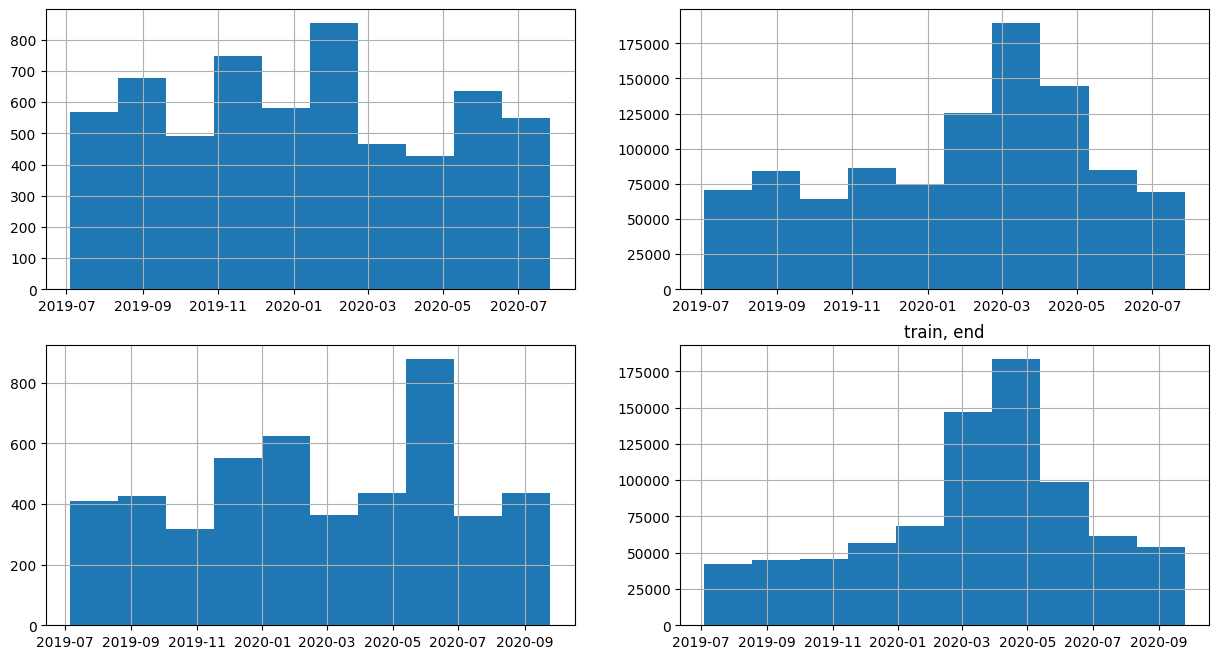

In [1280]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(15,8))
prueba.start_date.hist(ax=ax[0,0])
ax[0,0] = plt.title('test, start')
prueba.end_date.hist(ax=ax[1,0])
ax[1,0] = plt.title('test, end')
train.start_date.hist(ax=ax[0,1])
ax[0,1] = plt.title('train, start')
train.end_date.hist(ax=ax[1,1])
ax[1,1] = plt.title('train, end')


# Limpieza y transformación de datos (magia parte 2 -- MD)

In [1281]:
raro = df_test['surface_total']<df_test['surface_covered']

df_test.loc[raro,'surface_total'], df_test.loc[raro,'surface_covered'] = df_test.loc[raro,'surface_covered'], df_test.loc[raro,'surface_total']

In [1282]:
raro = df_train['surface_total']<df_train['surface_covered']

df_train.loc[raro,'surface_total'], df_train.loc[raro,'surface_covered'] = df_train.loc[raro,'surface_covered'], df_train.loc[raro,'surface_total']

In [1283]:
en_amba_train = (df_train.lat>-60)&(df_train['lon']>-35.5)&(df_train['lon']<-34)& (df_train.lat<-56.5) & (df_train.l1=='Argentina')
en_amba_test  =  (df_test.lat>-60)&(df_test['lon']>-35.5)&(df_test['lon']<-34)& (df_test.lat<-56.5) & (df_test.l1=='Argentina')

# en_ballester = ((df_train.title.str.upper().str.contains('BALLESTER')) | (df_train.description.str.upper().str.contains('BALLESTER'))&
#                 en_amba_train)
# ballester = df_train[en_ballester]

no_lugares = ['Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']

#Filtramos los que se encuentran dentro del rango de AMBA y que no son del conurbano
df_train = df_train[en_amba_train & (~df_train.l2.isin(no_lugares))]

#Pulimos la zona circundante a la plata para que coincida con el test
df_train = df_train[(df_train.l2=='Capital Federal')|((df_train.l2=='Buenos Aires Interior')&(df_train.lat>-58.15)&(df_train.lon<-34.7)&(df_train.lon>-35.1))]

# df_train = pd.concat((df_train,ballester),axis=0)

df_train = df_train[(df_train.price_period=='Mensual')|(df_train.price_period.isnull())] #TODO ver si sacarlo 

df_train.loc[df_train.l2=='Buenos Aires Interior','l2'] = 'Bs.As. G.B.A. Zona Sur'

df_train = df_train[df_train.operation_type=='Venta']

df_test.loc[df_test.title.str.contains('en Las Cañitas'),'l3'] = "Las Cañitas"
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas')) & (df_test.lat<-58.4),'lat'] = np.nan

df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.47),'l3'] = 'Villa Urquiza'
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.44),['lat','lon']] = np.nan

df_train.shape

(152720, 24)

In [1284]:
df_test.loc[~en_amba_test,['lat','lon']] = np.nan

In [1285]:
cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']
# crear nuevas columnas para indicar los valores imputados
for column in cols_a_imputar:
    is_imputed_train = np.where(df_train[column].isnull(), True, False)
    is_imputed_test = np.where(df_test[column].isnull(), True, False)
    df_train[column + '_imputed'] = is_imputed_train
    df_test[column + '_imputed'] = is_imputed_test

In [1286]:
#df_train['train_test'] = 'train'
#df_test['train_test'] = 'test'

#df = pd.concat((df_train,df_test),axis=0)

#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(dos|2) baños'))   ,'bathrooms'] = 2
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(tres|3) baños'))  ,'bathrooms'] = 3
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cuatro|4) baños')),'bathrooms'] = 4
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cinco|5) baños')) ,'bathrooms'] = 5
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(seis|6) baños'))  ,'bathrooms'] = 6
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('baño(\ |\.|\,)'))  ,'bathrooms'] = 1

#df_train = df[df.train_test=='train']
#df_test = df[df.train_test=='test']

#df_train.drop(columns='train_test',inplace=True)
#df_test.drop(columns='train_test',inplace=True)

In [1287]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [1288]:
imp = IterativeImputer(max_iter=10, random_state=42)  # tiene add_indicator

cols_a_imputar = ['rooms','bedrooms','bathrooms', 'surface_total','surface_covered']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

cols_a_imputar = ['lat','lon']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [1289]:

df_test.rooms      = df_test.rooms.astype('int')
df_train.rooms     = df_train.rooms.astype('int')
df_test.bedrooms   = df_test.bedrooms.astype('int')
df_train.bedrooms  = df_train.bedrooms.astype('int')
df_test.bathrooms  = df_test.bathrooms.astype('int')
df_train.bathrooms = df_train.bathrooms.astype('int')

## Filtrado

In [1290]:
pd.concat((df_train.property_type.value_counts(dropna=False),
           df_test.property_type.value_counts(dropna=False)),axis=1).sort_index()

,property_type,property_type
Casa,6878,NaN
Casa de campo,7,NaN
Cochera,2894,NaN
Departamento,97209,5426.0
Depósito,917,NaN
Local comercial,5940,NaN
Lote,8230,NaN
Oficina,4983,NaN
Otro,15649,NaN
PH,10013,574.0


In [1291]:
df_train = df_train[df_train.property_type.isin(['PH','Departamento'])]

In [1292]:
pd.concat((df_train.bathrooms.value_counts(dropna=False),
           df_test.bathrooms.value_counts(dropna=False)),axis=1)

,bathrooms,bathrooms
1,72464,4605.0
2,23804,1227.0
3,6969,144.0
4,2254,20.0
0,915,NaN
5,633,1.0
6,113,3.0
7,28,NaN
8,12,NaN
11,4,NaN


In [1293]:
df_train = df_train[(df_train['bathrooms']<=6) | (df_train['bathrooms'].isnull())]
df_train.shape

(107152, 31)

In [1294]:
pd.concat((df_train.currency.value_counts(dropna=False),
           df_test.currency.value_counts(dropna=False)),axis=1)

,currency,currency
USD,102422,6000.0
None,3910,NaN
ARS,820,NaN


In [1295]:
df_train = df_train[df_train.currency=='USD'] #saco tambien los nulos porque no tienen precio
df_train.shape

(102422, 31)

In [1296]:
pd.concat((df_train.rooms.value_counts(dropna=False),
           df_test.rooms.value_counts(dropna=False)),axis=1).sort_index()

,rooms,rooms
1,20682,NaN
2,30582,2984.0
3,26593,3016.0
4,17756,NaN
5,4668,NaN
6,1264,NaN
7,481,NaN
8,258,NaN
9,46,NaN
10,45,NaN


In [1297]:
# df_train = df_train[(df_train.rooms<7) |(df_train.rooms.isnull())]
df_train.shape

(102422, 31)

In [1298]:
pd.concat((df_train.bedrooms.value_counts(dropna=False),
           df_test.bedrooms.value_counts(dropna=False)),axis=1).sort_index()

,bedrooms,bedrooms
-1,2,NaN
0,15245,3.0
1,38133,3312.0
2,27821,2660.0
3,16558,23.0
4,3729,1.0
5,507,1.0
6,227,NaN
7,144,NaN
8,22,NaN


In [1299]:
# df_train = df_train[(df_train.bedrooms<6) |(df_train.bedrooms.isnull())]
df_train.shape

(102422, 31)

<AxesSubplot: xlabel='surface_covered'>

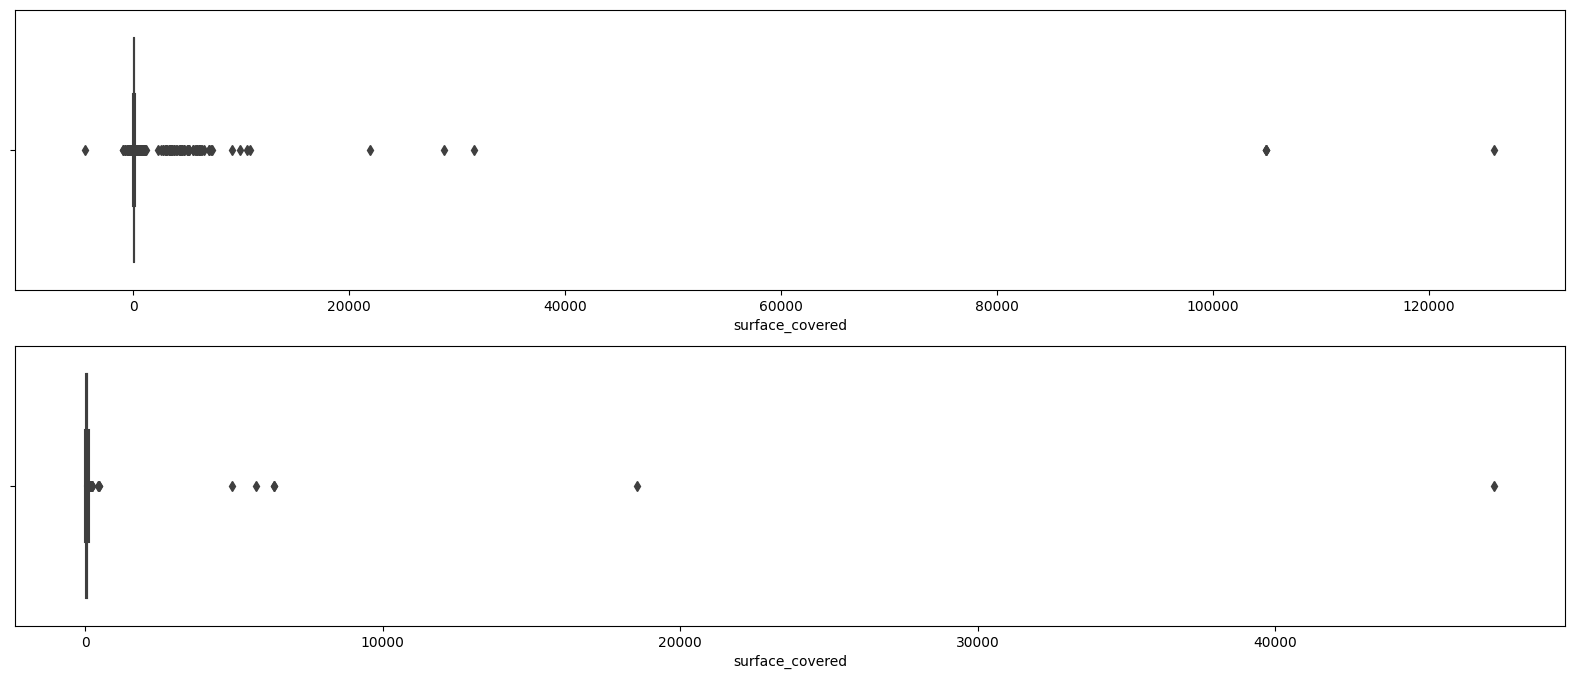

In [1300]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_covered',ax=ax[0])
sns.boxplot(data=df_test,x='surface_covered',ax=ax[1])

In [1301]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,102422.0,87.192914,720.887917,-4432.263411,41.0,61.0,98.0,126062.0
surface_total,102422.0,138.086412,1024.722444,-149575.086421,43.0,69.0,130.0,126062.0


In [1302]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [1303]:
df_train = df_train[((df_train['surface_covered']>=20)&(df_train['surface_covered']<50000))|(df_train['surface_covered'].isnull())]
df_train.shape

(100591, 31)

<AxesSubplot: xlabel='surface_total'>

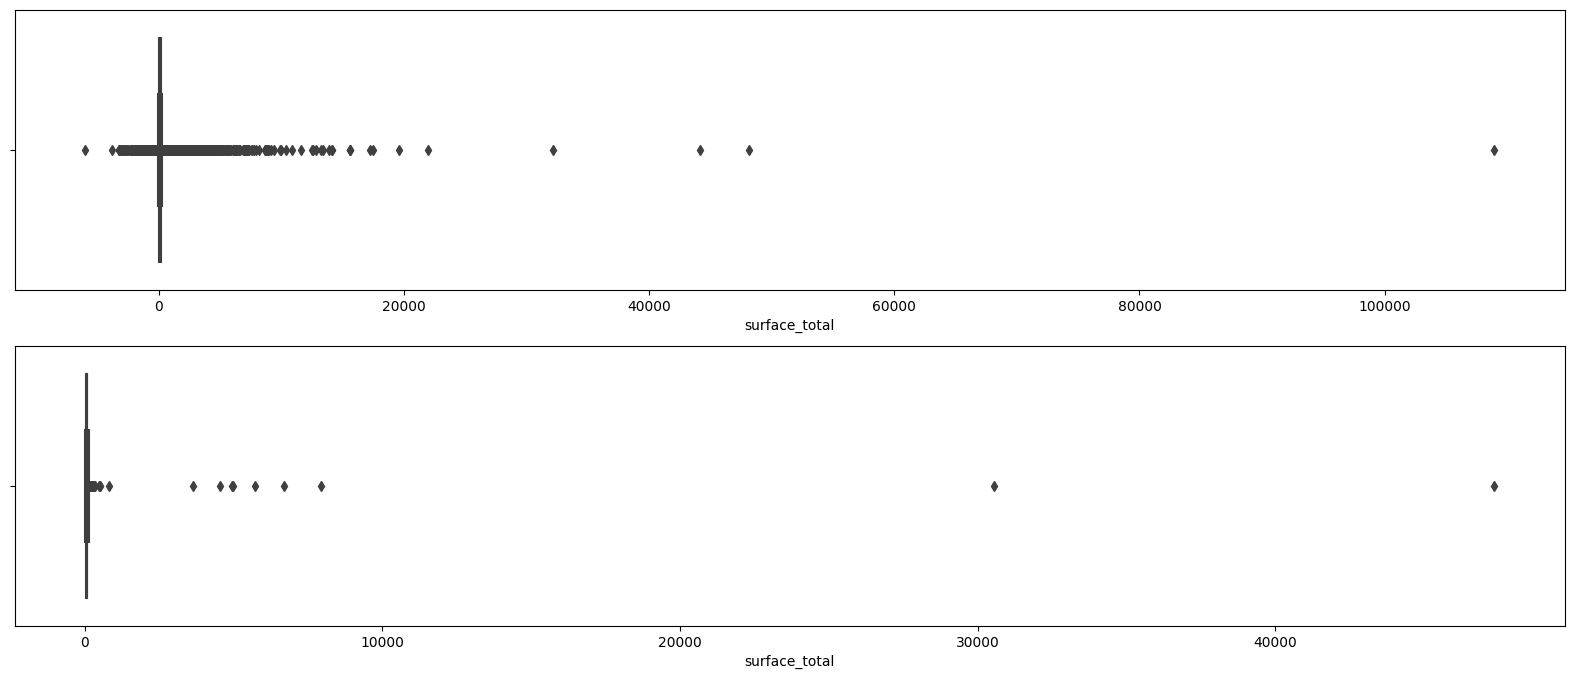

In [1304]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_total',ax=ax[0])
sns.boxplot(data=df_test,x='surface_total',ax=ax[1])

In [1305]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,100591.0,85.257393,207.768667,20.000000,41.044627,62.0,100.0,31550.0
surface_total,100591.0,146.328567,580.711035,-6008.880032,43.000000,70.0,130.0,108960.0


In [1306]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [1307]:
df_train = df_train[((df_train['surface_total']>=10)&(df_train['surface_total']<50000))|(df_train['surface_total'].isnull())]
df_train.shape

(95914, 31)

In [1308]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,95914.0,82.577618,212.001841,20.0,41.0,60.0,91.0,31550.0
surface_total,95914.0,169.079044,457.650534,12.0,46.0,73.0,138.0,48170.0


In [1309]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [1310]:
df_train.price.value_counts().sort_index()

5000.0        1
9500.0        1
10000.0       5
10500.0       2
11111.0       1
             ..
9477000.0     3
11111111.0    1
12345678.0    1
15011160.0    1
32434232.0    1
Name: price, Length: 6371, dtype: int64

## Imputación de nulos

## Armado de variables

In [1311]:
df = pd.concat((df_train,df_test),axis=0)

df['bathrooms_rooms'] = df['bathrooms']/df['rooms']
df['bedrooms_rooms'] = df['bedrooms']/df['rooms']
df['covered'] = df['surface_covered']/df['surface_total']

df['start_year']  = pd.to_datetime(df['start_date']).dt.year
df['start_month'] = pd.to_datetime(df['start_date']).dt.month
df['start_day'] = pd.to_datetime(df['start_date']).dt.month

df['tiene_esp_abierto'] = 0
df.loc[(df['surface_total']-df['surface_covered'])!=0,'tiene_esp_abierto'] = 1

df['description'] = df["description"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')
#df['title'] = df["title"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')

for c in ["barrio privado", "corredor",'suite','monoambiente','amueblado',
          'ascensor','parrilla','patio','balcon','jardin','linea (a|b|b|c|d|e|h)',
          'obelisco','catedral','metrobus','barrancas','barrio chino','river',
          'universidad','facultad','subte','tren','estacion','museo','parque','jacuzzi',
          '(j|y)acu(z|zz)i','sho(pp|p)ing','country','terminal','avenida','av.','av',
          'expensa','expensas','a(mm|m)enities','inmobiliaria','dueñ(o|a) direct(o|a)',
          'balcon','pileta|piscina','escuela|colegio','centro','microcentro','lago','estilo franc(é|e)s',
          'libertador','baulera','hotel','emprendimiento']:
    df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
    #df[f"title_{c}"] = df["title"].str.contains(c,regex=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2069691848.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.ex

In [1312]:
df.covered.value_counts(dropna=False).sort_index()

0.000851     1
0.004233     1
0.004679     1
0.005105     1
0.007350     1
            ..
19.352209    2
20.143609    1
21.003826    2
24.100608    1
26.738608    1
Name: covered, Length: 5677, dtype: int64

In [1313]:
# from sklearn.preprocessing import LabelEncoder

# labelencoder = LabelEncoder()

# df['l3'] = labelencoder.fit_transform(df['l3'])

In [1314]:
df_train = df[~df.price.isnull()]
df_test = df[df.price.isnull()]

## Selección de atributos

In [1315]:
cols = ['l1','l5','l6','ad_type','currency','operation_type']
df_train.drop(cols,inplace=True,axis=1)
df_test.drop(cols,inplace=True,axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2438721469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(cols,inplace=True,axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2438721469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(cols,inplace=True,axis=1)


## Dummies

In [1316]:
cols_dummies = ['l2','l3','l4','property_type']
train_dummies = pd.get_dummies(df_train[cols_dummies],dummy_na=True)
df_train = pd.concat((df_train,train_dummies),axis=1)

test_dummies = pd.get_dummies(df_test[cols_dummies],dummy_na=True)
df_test = pd.concat((df_test,test_dummies),axis=1)

In [1317]:
cols = pd.concat((df_train,df_test),axis=0,join='inner').columns

df_train = df_train[cols]
df_test = df_test[cols]

## Borrado por varianza

In [1318]:
from sklearn.feature_selection import VarianceThreshold

In [1319]:
# F = df_train[~df_train.price.isnull()]
# X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
# y = F['price']

# print(X.shape)
# fs = VarianceThreshold(threshold=0.005)
# X_new = fs.fit_transform(X) # threshold = limite superior de la varianza
# print(X_new.shape)

# cols = list(X.columns[fs.get_support()])
# cols.append('price')

# df_train = df_train[cols]
# df_test = df_test[cols]

In [1320]:
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))&(df_train.lat<-58.42),'lat'] = -58.361

In [1321]:
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))&(df_test.lat<-58.4),'lat'] = -58.361

<AxesSubplot: xlabel='lat', ylabel='lon'>

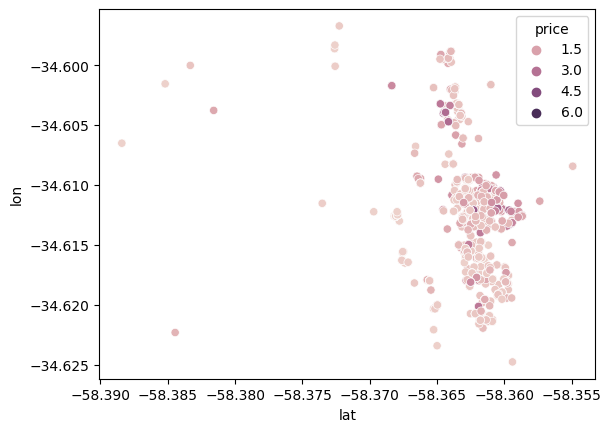

In [1322]:
sns.scatterplot(data=df_train[(df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')],x='lat',y='lon',hue='price')

In [1323]:
# df_test['lat'], df_test['lon'] = df_test['lon'], df_test['lat']
# df_train['lat'], df_train['lon'] = df_train['lon'], df_train['lat']
# from shapely.geometry import Point
# df_test['punto'] = df_test.apply(lambda row: Point(row['lat'], row['lon']), axis=1)
# df_train['punto'] = df_train.apply(lambda row: Point(row['lat'], row['lon']), axis=1)

## División de base

In [1324]:
df_test_la_plata = df_test[(df_test.lat>-58.2)&(df_test.lon<-34.8)]
df_train_la_plata = df_train[(df_train.lat>-58.2)&(df_train.lon<-34)]

df_test_caba = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&~((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]
df_train_caba = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&~((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

In [1325]:
df_test_madero = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]

df_train_madero = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

corredor_norte = ['Retiro','Recoleta','Barrio Norte']#,'Nuñez','Distrito Audiovisual','Palermo','Belgrano','Coghlan','Las Cañitas',]

df_train_corredor_norte = df_train_caba[df_train_caba.l3.isin(corredor_norte)]
df_test_corredor_norte = df_test_caba[df_test_caba.l3.isin(corredor_norte)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_norte)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_norte)]

corredor_sur = ['Villa Riachuelo','Villa Lugano','Villa Soldati','Pompeya','Boca','Constitución']#'Barracas','Parque Patricios']

df_train_corredor_sur = df_train_caba[df_train_caba.l3.isin(corredor_sur)]
df_test_corredor_sur = df_test_caba[df_test_caba.l3.isin(corredor_sur)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_sur)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_sur)]

caballito = ['Almagro','Caballito','Parque Centenario','Villa Crespo']

df_train_caballito = df_train_caba[df_train_caba.l3.isin(caballito)]
df_test_caballito= df_test_caba[df_test_caba.l3.isin(caballito)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(caballito)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(caballito)]

palermo = ['Palermo','Distrito Audiovisual','Las Cañitas']
df_train_palermo = df_train_caba[df_train_caba.l3.isin(palermo)]
df_test_palermo= df_test_caba[df_test_caba.l3.isin(palermo)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(palermo)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(palermo)]

belgrano = ['Belgrano','Nuñez','Coghlan']
df_train_belgrano = df_train_caba[df_train_caba.l3.isin(belgrano)]
df_test_belgrano= df_test_caba[df_test_caba.l3.isin(belgrano)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(belgrano)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(belgrano)]

# noroeste = ['Saavedra','Villa Ortuzar','Villa Urquiza']#,'Coghlan']

# df_train_noroeste = df_train_caba[df_train_caba.l3.isin(noroeste)]
# df_test_noroeste= df_test_caba[df_test_caba.l3.isin(noroeste)]

# df_train_caba = df_train_caba[~df_train_caba.l3.isin(noroeste)]
# df_test_caba = df_test_caba[~df_test_caba.l3.isin(noroeste)]

# centro = ['San Nicolás','Monserrat','Tribunales','Centro / Microcentro']

# df_train_centro = df_train_caba[df_train_caba.l3.isin(centro)]
# df_test_centro= df_test_caba[df_test_caba.l3.isin(centro)]

# df_train_caba = df_train_caba[~df_train_caba.l3.isin(centro)]
# df_test_caba = df_test_caba[~df_test_caba.l3.isin(centro)]

#devoto
df_train_devoto = df_train_caba[df_train_caba.l3=='Villa Devoto']
df_test_devoto = df_test_caba[df_test_caba.l3=='Villa Devoto']

df_train_caba = df_train_caba[df_train_caba.l3!='Villa Devoto']
df_test_caba= df_test_caba[df_test_caba.l3!='Villa Devoto']

# #barracas
# df_train_barracas = df_train_caba[df_train_caba.l3=='Barracas']
# df_test_barracas = df_test_caba[df_test_caba.l3=='Barracas']

# df_train_caba = df_train_caba[df_train_caba.l3!='Barracas']
# df_test_caba= df_test_caba[df_test_caba.l3!='Barracas']

### Corrección de price y surface

In [1326]:
df_train_devoto = df_train_devoto[~((df_train_devoto.l3=='Villa Devoto') &(df_train_devoto.price>=2215000))]

In [1327]:
df_train_caba = df_train_caba[~((df_train_caba.l3=='Barracas')&(df_train_caba.title.fillna('NA').str.contains('600000')))]

df_train_belgrano = pd.concat((df_train_belgrano,df_train_caba[df_train_caba.title.fillna('NA').str.contains('Barrancas')]),axis=0)

df_train_caba = df_train_caba[~df_train_caba.title.fillna('NA').str.contains('Barrancas')]


df_train_caba = df_train_caba[~((df_train_caba.l3=='Villa Urquiza')&(df_train_caba.price==3900000.0))]

df_train_madero = pd.concat((df_train_madero,df_train_caba[(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]),axis=0)
df_train_caba = df_train_caba[~(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]

df_train_madero = pd.concat((df_train_caba[(df_train_caba.l3=='Tribunales')&(df_train_caba.price>2000000)],df_train_madero),axis=0)
df_train_caba = df_train_caba[~((df_train_caba.l3=='Tribunales')&(df_train_caba.price>2000000))]

df_train_caba = df_train_caba[~((df_train_caba.l3=='Boedo')&(df_train_caba.price>3000000))] #TODO: ver si reincorporar
df_train_caba = df_train_caba[~((df_train_caba.l3=='San Cristobal')&(df_train_caba.price>3000000))] #TODO: ver si reincorporar
df_train_caba = df_train_caba[~((df_train_caba.l3=='Centro / Microcentro')&(df_train_caba.price>2000000))] #TODO: ver si reincorporar
df_train_caba = df_train_caba[~((df_train_caba.l3=='Chacarita')&(df_train_caba.price>500000))]#TODO: ver si reincorporar

<AxesSubplot: xlabel='price', ylabel='l3'>

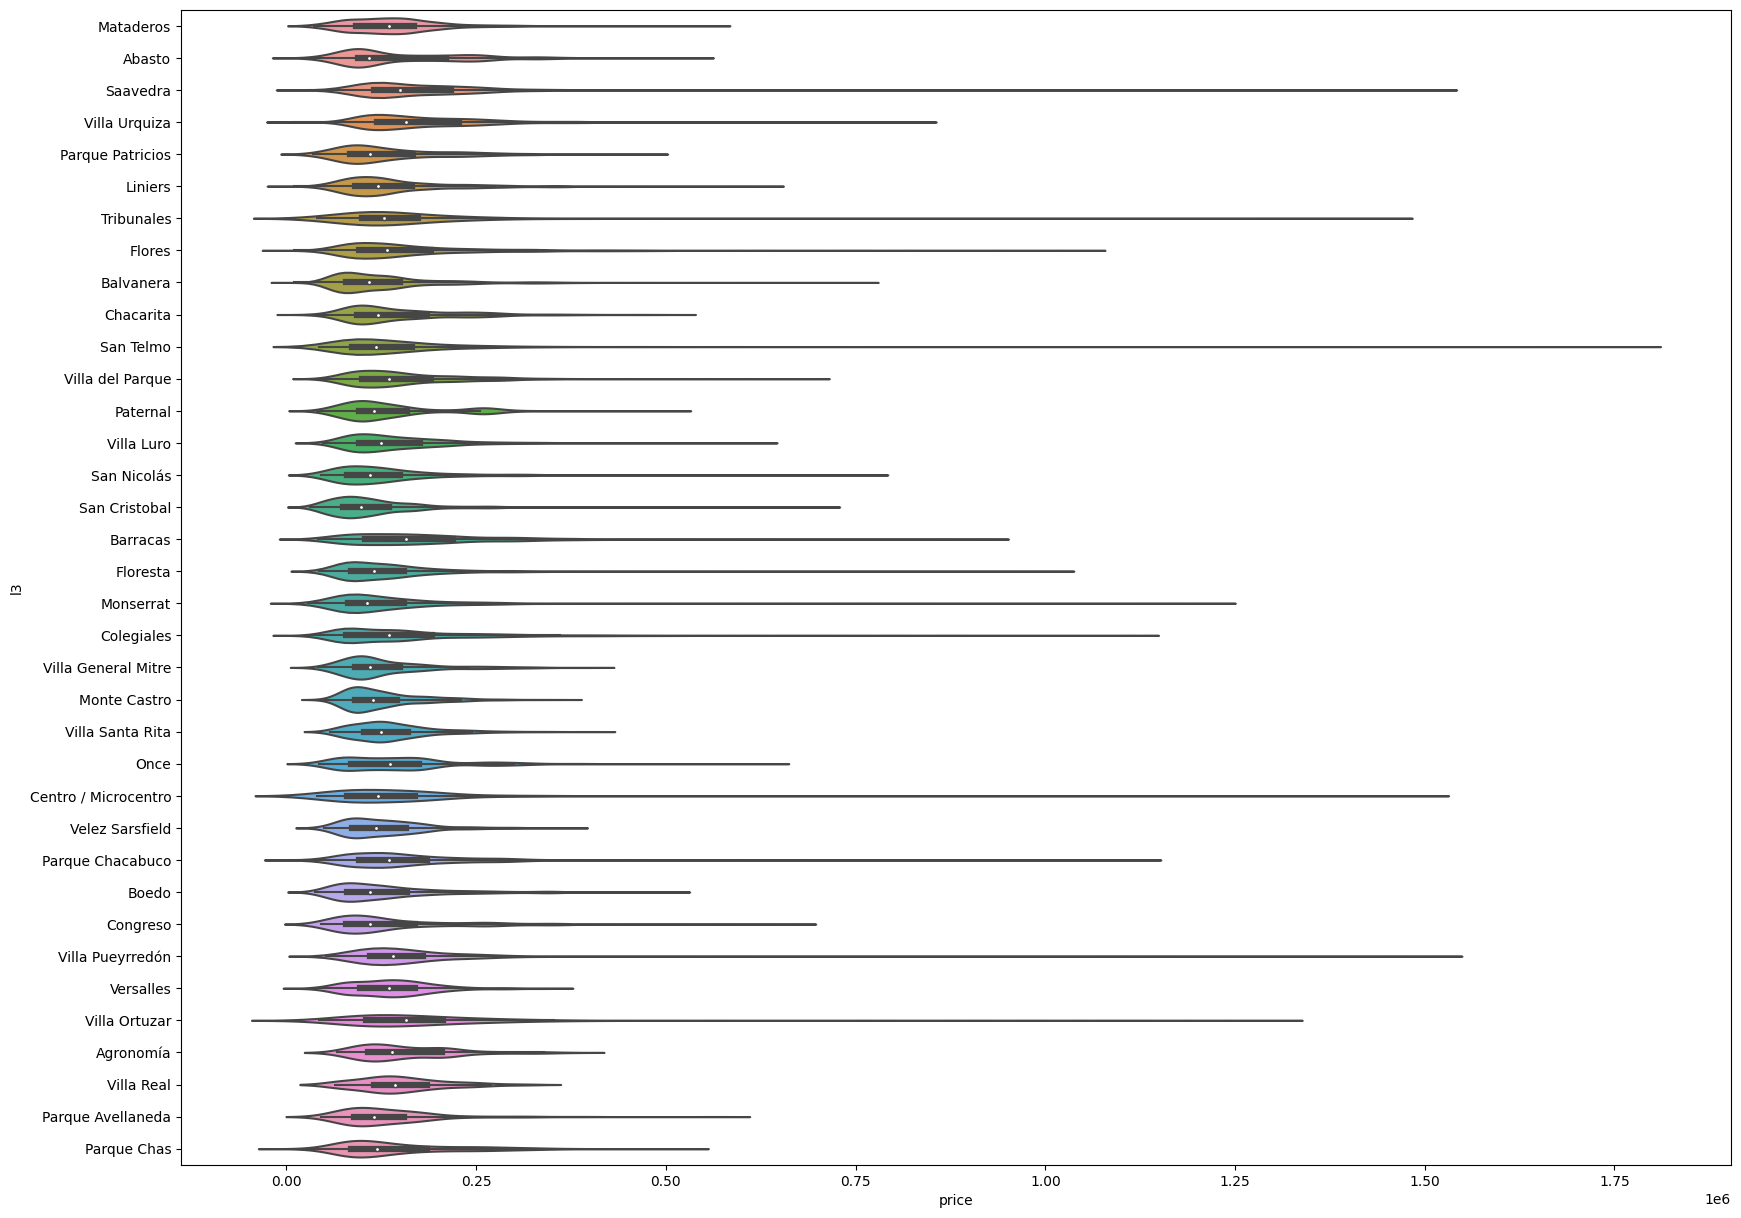

In [1328]:
plt.figure(figsize=(20,15))
sns.violinplot(data=df_train_caba,x='price',y='l3')

In [1329]:
df_train_palermo.loc[df_train_palermo.price==32434232,'price'] = 32434232/10

In [1330]:
df_train_caballito = df_train_caballito[~((df_train_caballito.l3=='Villa Crespo')&
                     (df_train_caballito.price>1200000)&
                     (df_train_caballito.title.str.lower().str.contains('emprendimiento')))]

df_train_caballito = df_train_caballito[~((df_train_caballito.l3=='Caballito')&(df_train_caballito.price>4000000))] #TODO: ver si reincorporar

In [1331]:
df_train_corredor_sur.loc[((df_train_corredor_sur.price==1111111)),'price'] = df_train_corredor_sur.loc[((df_train_corredor_sur.price==1111111)),'price']/10
df_train_corredor_sur.loc[((df_train_corredor_sur.price==1115000)),'price'] = df_train_corredor_sur.loc[((df_train_corredor_sur.price==1115000)),'price'] /10

In [1332]:
df_train_corredor_sur.loc[((df_train_corredor_sur.price>800000)),'price'] = df_train_corredor_sur.loc[((df_train_corredor_sur.price>800000)),'price']/10

In [1333]:
df_train_madero = df_train_madero[(df_train_madero.price<=4000000)] #TODO: ver si reincorporar en VERSION LAXA

In [1334]:
df_train_madero.shape

(1464, 148)

<AxesSubplot: xlabel='surface_covered', ylabel='l3'>

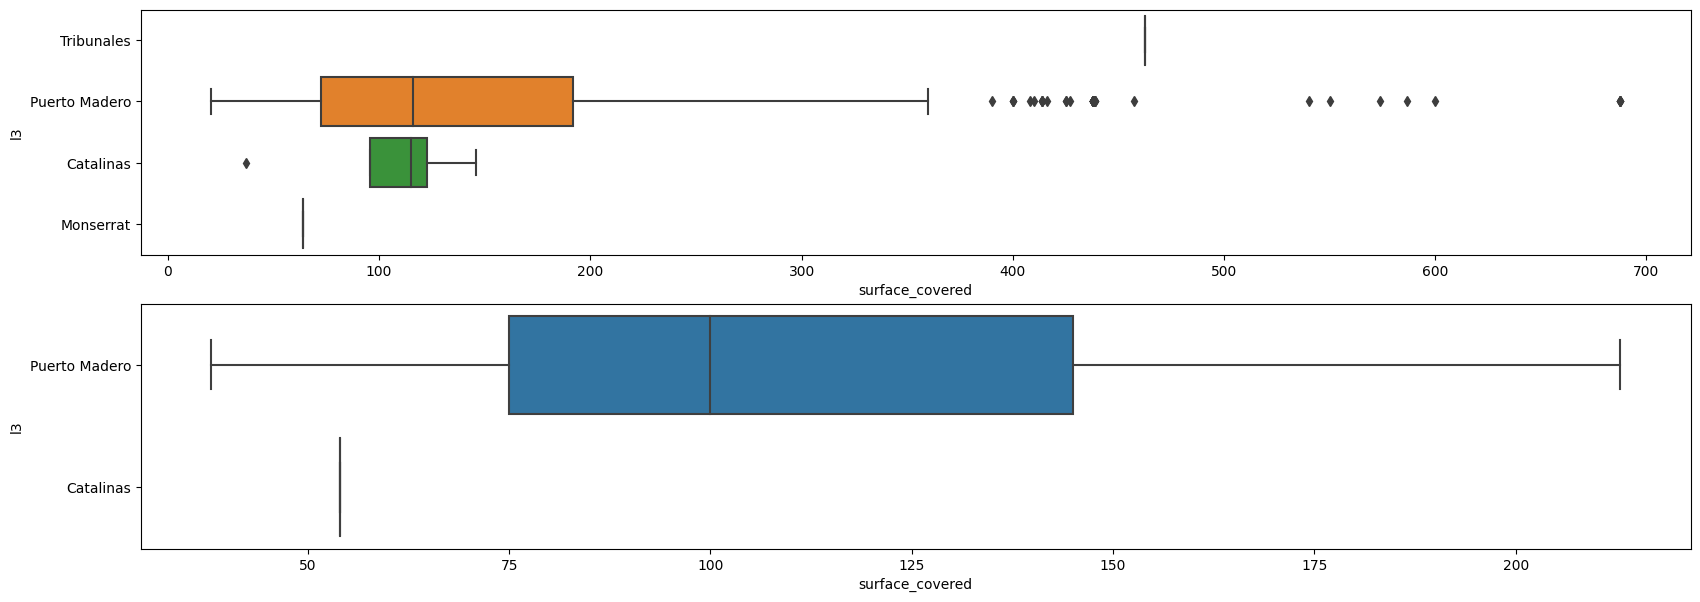

In [1335]:
fig, ax = plt.subplots(nrows=2,figsize=(20,7))

sns.boxplot(data=df_train_madero,x='surface_covered',y='l3',ax=ax[0])

sns.boxplot(data=df_test_madero,x='surface_covered',y='l3',ax=ax[1])

In [1336]:
df_test_madero.surface_covered.describe()

count    100.000000
mean     110.607751
std       46.913381
min       38.000000
25%       74.500000
50%      100.000000
75%      143.000000
max      213.000000
Name: surface_covered, dtype: float64

In [1337]:
df_train_madero = df_train_madero[df_train_madero.surface_covered<350]

In [1338]:
df_train_caba.loc[df_train_caba.surface_covered==21920,'surface_covered'] = df_train_caba.loc[df_train_caba.surface_covered==21920,'surface_covered']/10

In [1339]:
df_test_caba.loc[df_test_caba.surface_covered>1000,'surface_covered'] = df_test_caba.loc[df_test_caba.surface_covered>1000,'surface_covered']/10 #TODO : chequear

In [1340]:
df_train_caba.loc[(df_train_caba.surface_covered>1000)&(df_train_caba.rooms<3),'surface_covered'] = df_train_caba.loc[(df_train_caba.surface_covered>1000)&(df_train_caba.rooms<3),'surface_covered']/100
df_train_caba = df_train_caba[df_train_caba.surface_covered<1000]

<AxesSubplot: xlabel='surface_covered', ylabel='l3'>

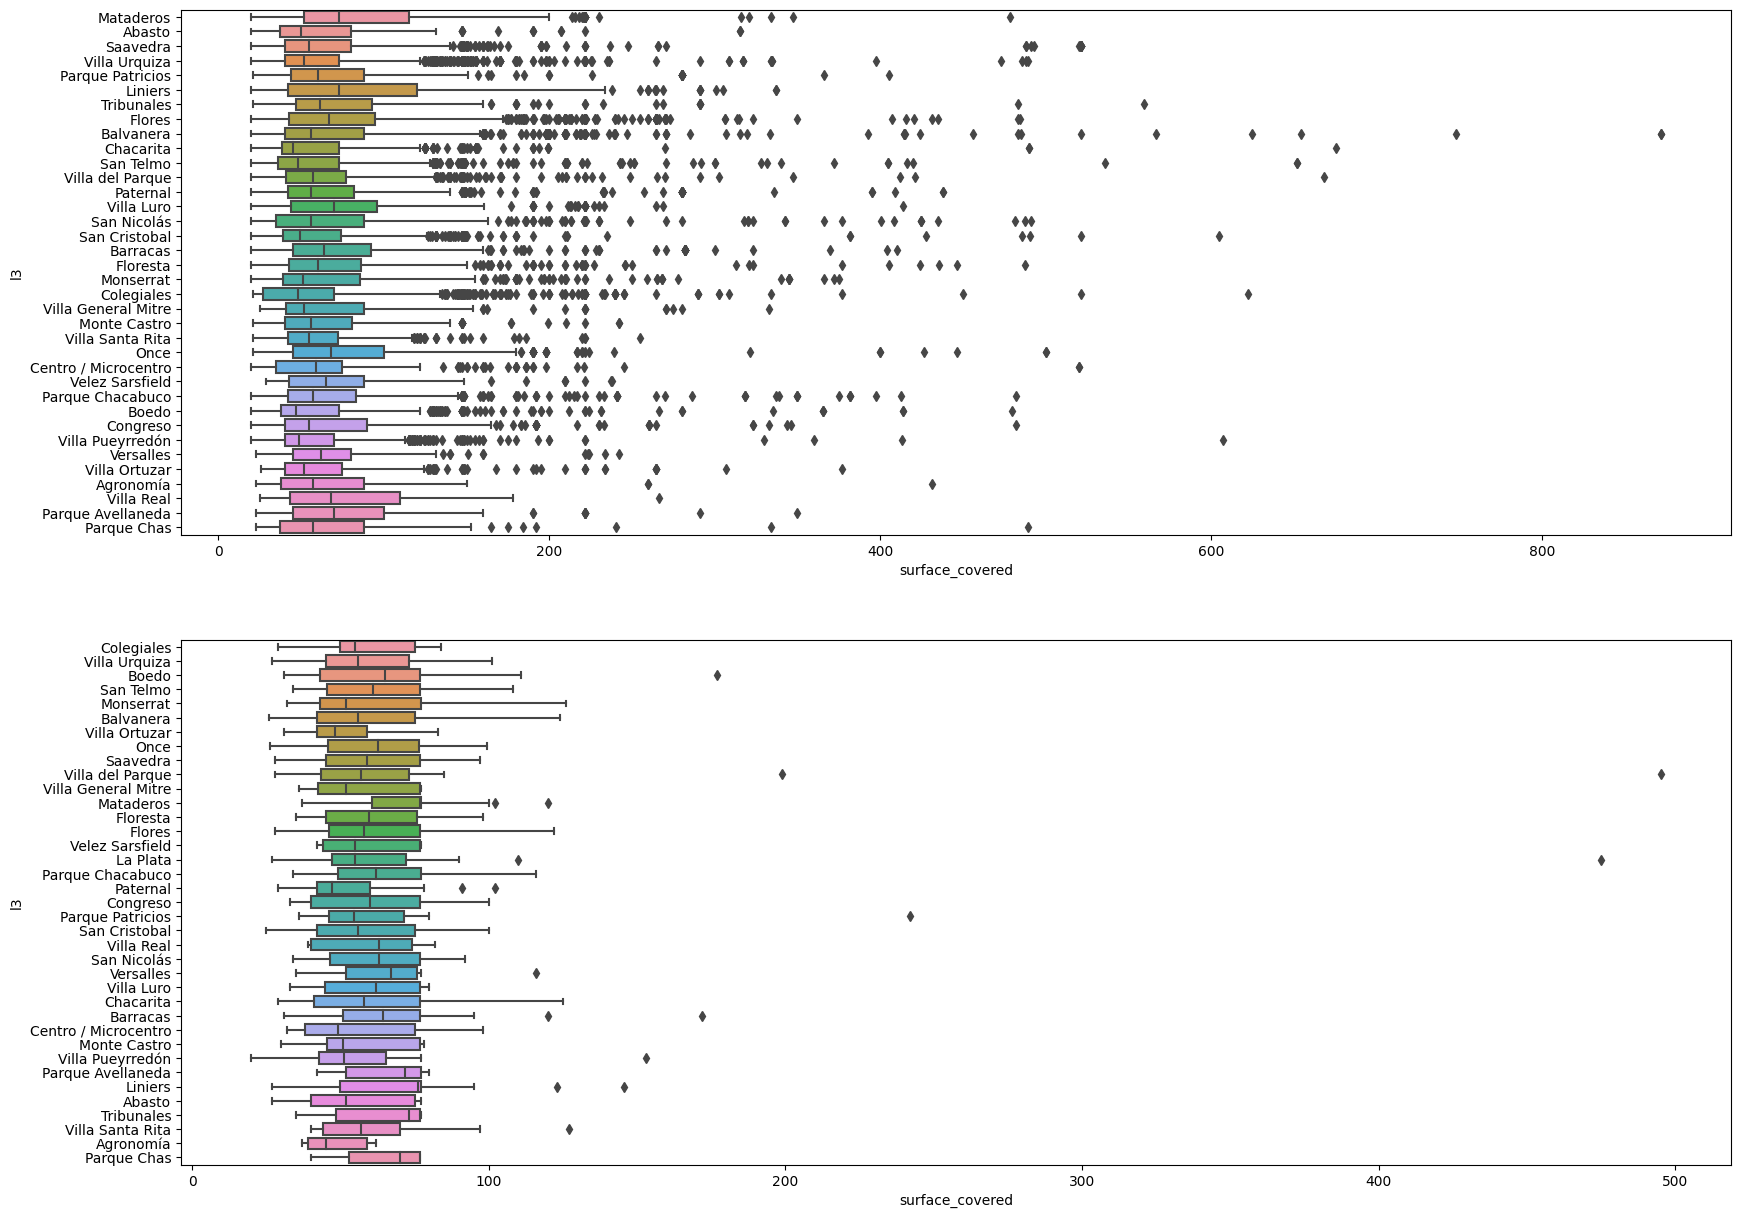

In [1341]:
fig, ax = plt.subplots(nrows=2,figsize=(20,15))

sns.boxplot(data=df_train_caba,x='surface_covered',y='l3',ax=ax[0])

sns.boxplot(data=df_test_caba,x='surface_covered',y='l3',ax=ax[1])

In [1342]:
df_train_corredor_norte.loc[(df_train_corredor_norte.surface_covered>1000)&(df_train_corredor_norte.rooms<7),'surface_covered'] = df_train_corredor_norte.loc[(df_train_corredor_norte.surface_covered>1000)&(df_train_corredor_norte.rooms<7),'surface_covered']/100

In [1343]:
df_test_corredor_norte.loc[df_test_corredor_norte.surface_covered>1000,'surface_covered'] = df_test_corredor_norte.loc[df_test_corredor_norte.surface_covered>1000,'surface_covered']/100

In [1344]:
df_train_corredor_norte = df_train_corredor_norte[df_train_corredor_norte.surface_covered<600]

<AxesSubplot: xlabel='surface_covered', ylabel='l3'>

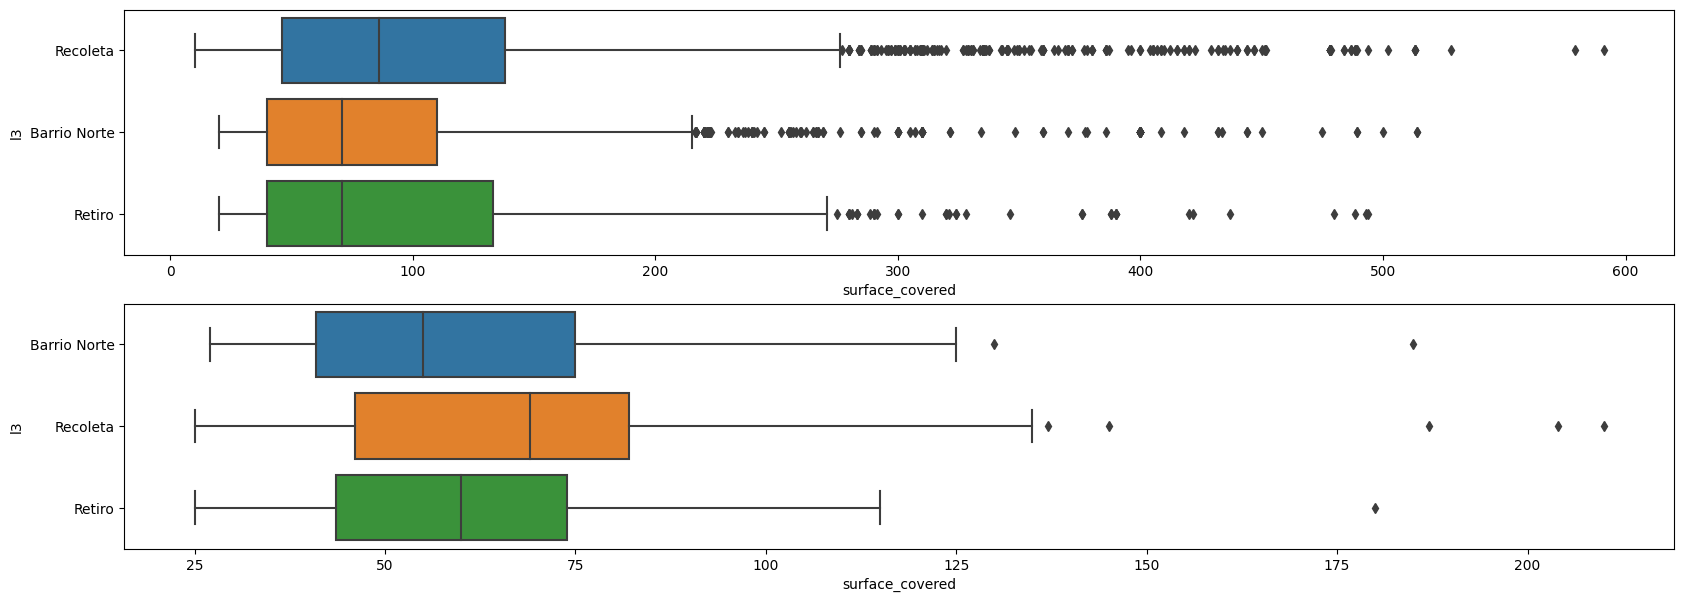

In [1345]:
fig, ax = plt.subplots(nrows=2,figsize=(20,7))

sns.boxplot(data=df_train_corredor_norte,x='surface_covered',y='l3',ax=ax[0])

sns.boxplot(data=df_test_corredor_norte,x='surface_covered',y='l3',ax=ax[1])

In [1346]:
df_train_palermo.loc[df_train_palermo.surface_covered>1000,'surface_covered'] = df_train_palermo.loc[df_train_palermo.surface_covered>1000,'surface_covered']/100

<AxesSubplot: xlabel='surface_covered', ylabel='l3'>

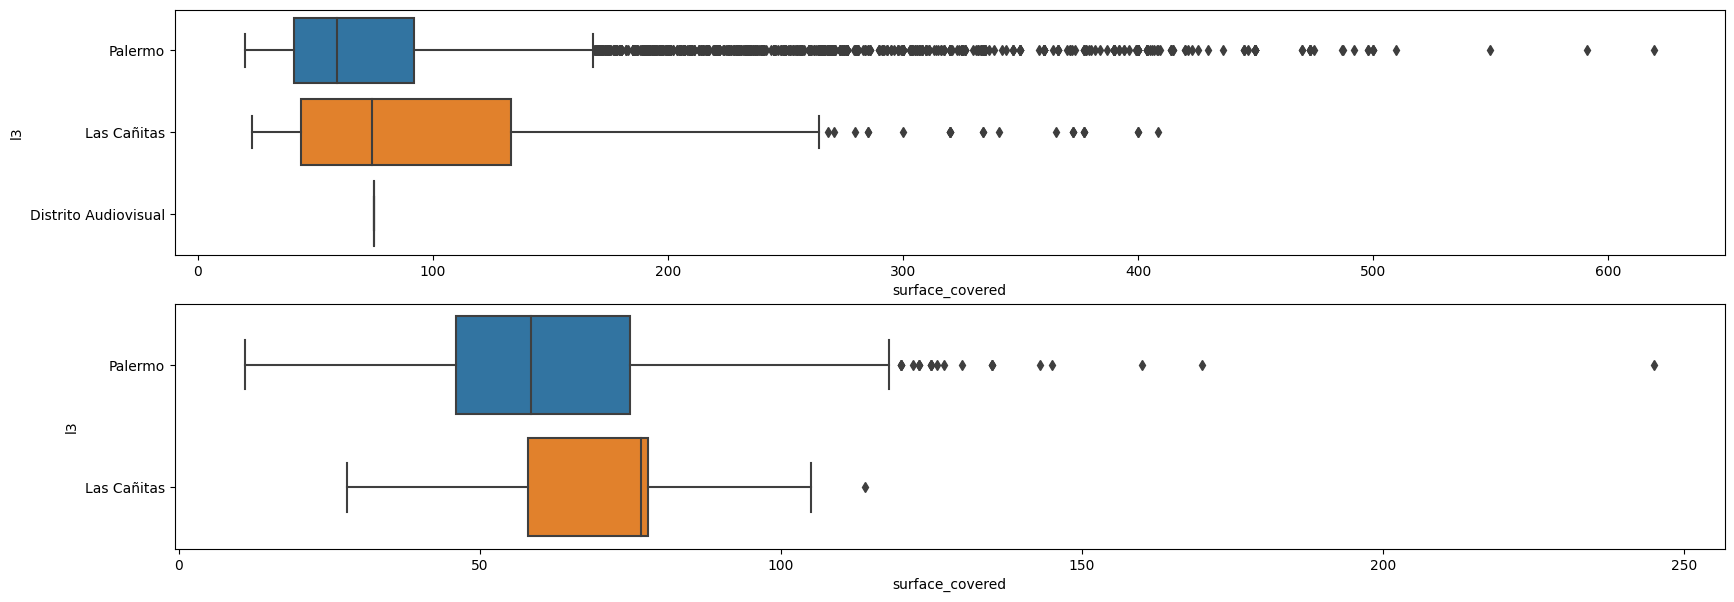

In [1347]:
fig, ax = plt.subplots(nrows=2,figsize=(20,7))

sns.boxplot(data=df_train_palermo,x='surface_covered',y='l3',ax=ax[0])

sns.boxplot(data=df_test_palermo,x='surface_covered',y='l3',ax=ax[1])

In [1348]:
df_train_belgrano.loc[df_train_belgrano.surface_covered>2000,'surface_covered'] = df_train_belgrano.loc[df_train_belgrano.surface_covered>2000,'surface_covered']/100

In [1349]:
df_train_belgrano = df_train_belgrano[df_train_belgrano.surface_covered<400]

<AxesSubplot: xlabel='surface_covered', ylabel='l3'>

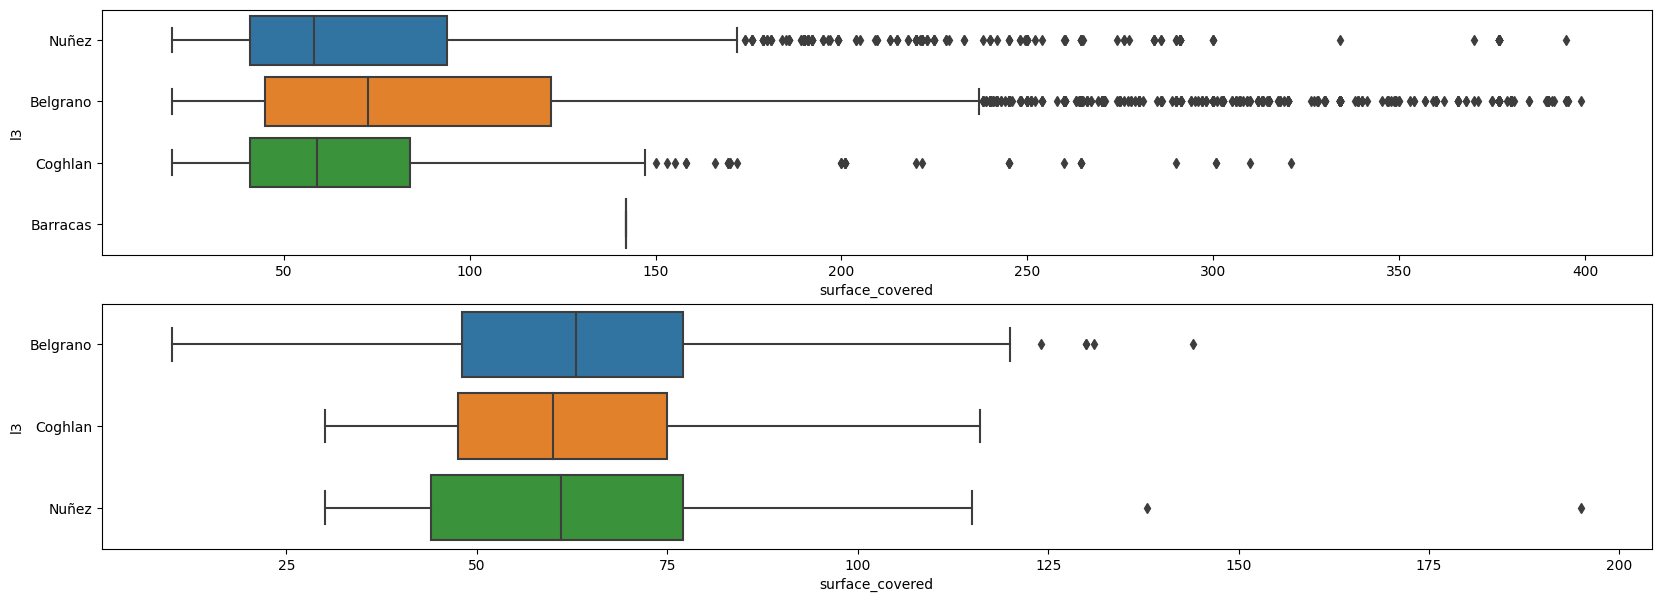

In [1350]:
fig, ax = plt.subplots(nrows=2,figsize=(20,7))

sns.boxplot(data=df_train_belgrano,x='surface_covered',y='l3',ax=ax[0])

sns.boxplot(data=df_test_belgrano,x='surface_covered',y='l3',ax=ax[1])

In [1351]:
df_train_devoto.loc[df_train_devoto.surface_covered>4000,'surface_covered'] = df_train_devoto.loc[df_train_devoto.surface_covered>4000,'surface_covered']/100

In [1352]:
df_test_devoto.loc[df_test_devoto.surface_covered>400,'surface_covered'] = df_test_devoto.loc[df_test_devoto.surface_covered>400,'surface_covered']/10

In [1353]:
df_train_devoto = df_train_devoto[df_train_devoto.surface_covered<300]

<AxesSubplot: xlabel='surface_covered', ylabel='l3'>

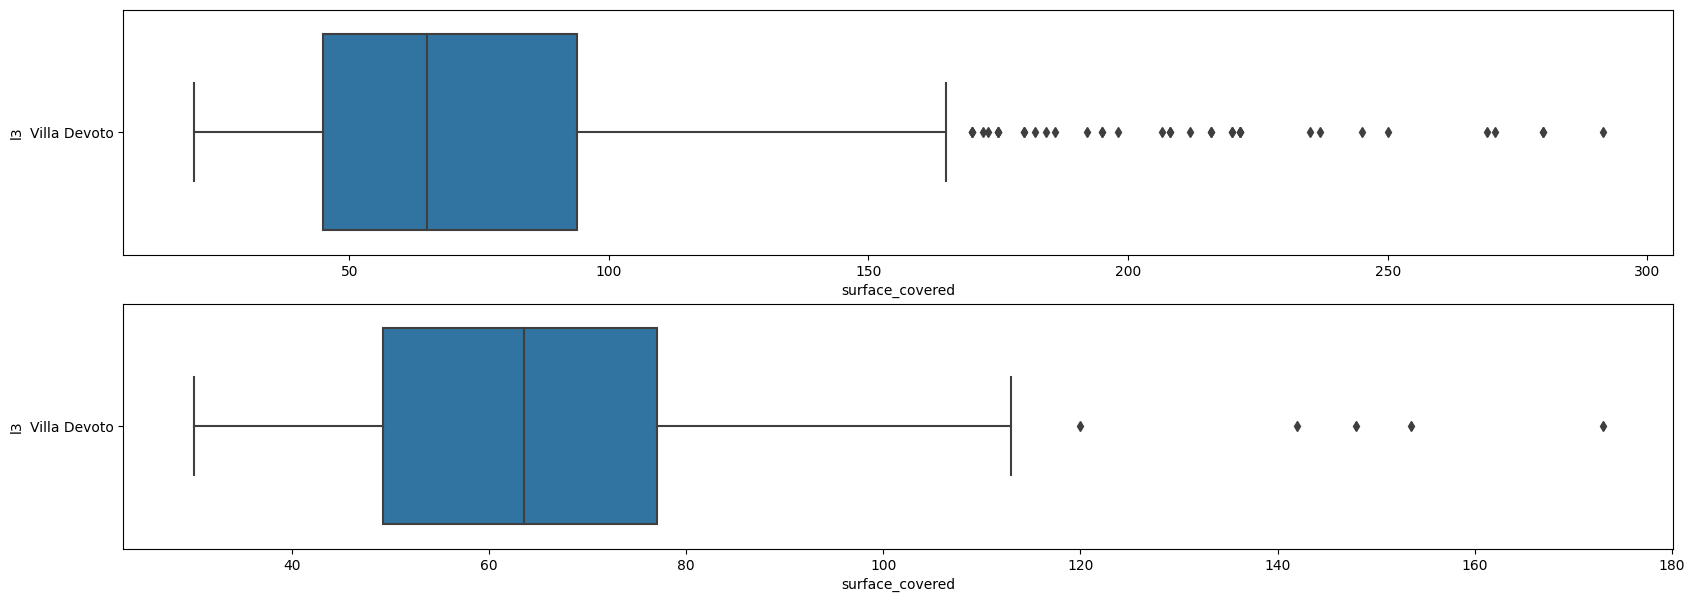

In [1354]:
fig, ax = plt.subplots(nrows=2,figsize=(20,7))

sns.boxplot(data=df_train_devoto,x='surface_covered',y='l3',ax=ax[0])

sns.boxplot(data=df_test_devoto,x='surface_covered',y='l3',ax=ax[1])

In [1355]:
df_train_corredor_sur = df_train_corredor_sur[df_train_corredor_sur.rooms<5]

In [1356]:
df_train_corredor_sur.loc[df_train_corredor_sur.surface_covered>900,'surface_covered'] = df_train_corredor_sur.loc[df_train_corredor_sur.surface_covered>900,'surface_covered']/100

In [1357]:
df_test_corredor_sur.loc[df_test_corredor_sur.surface_covered>900,'surface_covered'] = df_test_corredor_sur.loc[df_test_corredor_sur.surface_covered>900,'surface_covered']/100

<AxesSubplot: xlabel='surface_covered', ylabel='l3'>

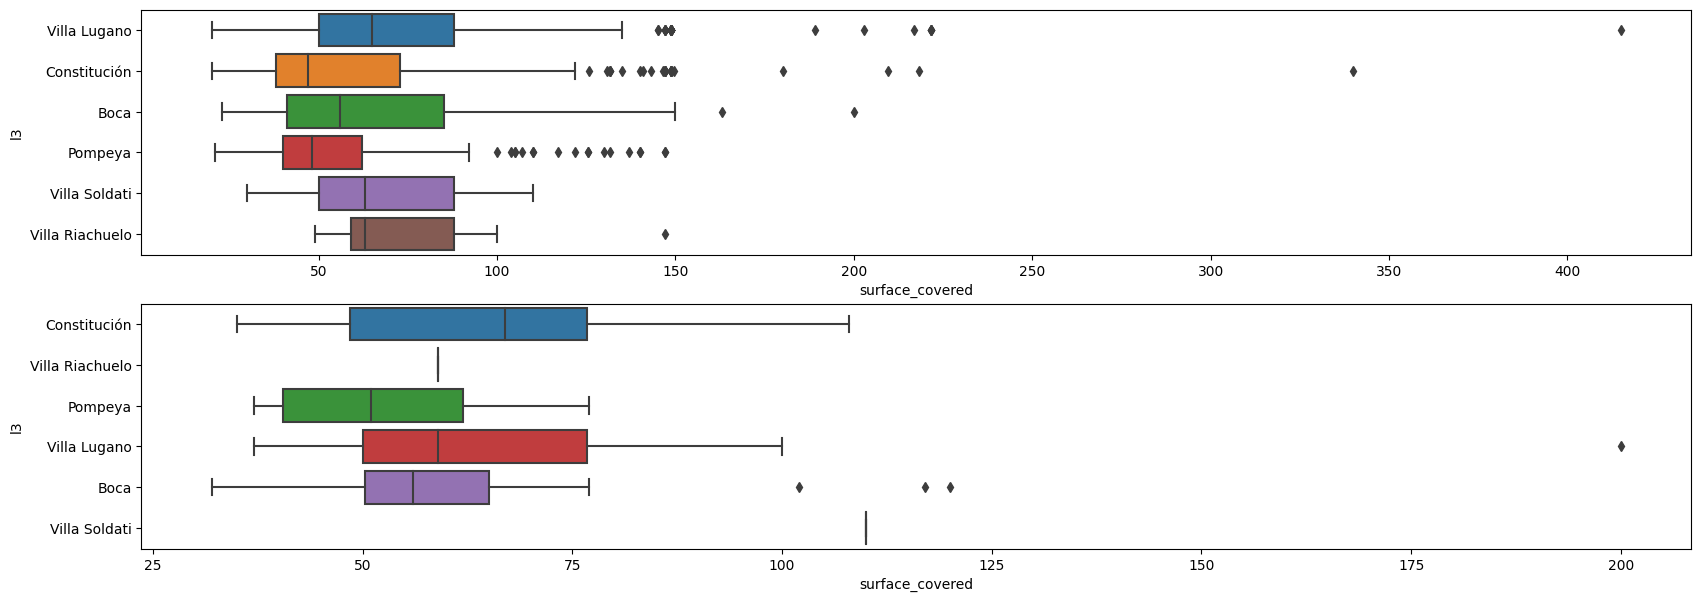

In [1358]:
fig, ax = plt.subplots(nrows=2,figsize=(20,7))

sns.boxplot(data=df_train_corredor_sur,x='surface_covered',y='l3',ax=ax[0])

sns.boxplot(data=df_test_corredor_sur,x='surface_covered',y='l3',ax=ax[1])

<AxesSubplot: xlabel='price', ylabel='l3'>

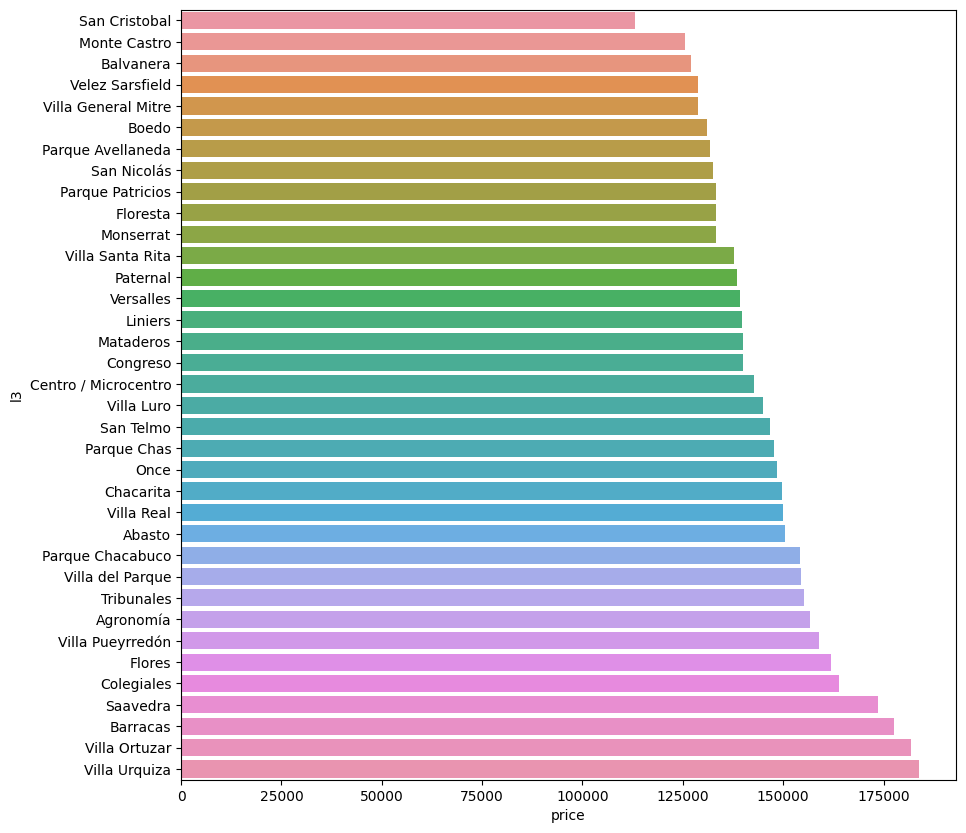

In [1359]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df_train_caba.groupby('l3').agg({'price':'mean'}).reset_index().sort_values('price'),y='l3',x='price')

In [1360]:
def filtrado_columnas(df_test,df_train):
    F = df_train[~df_train.price.isnull()]
    X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
    y = F['price']

    clf = sk.ensemble.RandomForestRegressor(n_estimators=50, n_jobs=-1,random_state=42)
    clf.fit(X, y)

    importancias = pd.DataFrame({'atributo': clf.feature_names_in_, 'importancia': clf.feature_importances_})
    cols = list(importancias[importancias['importancia']>0.0001].sort_values('importancia',ascending=False).reset_index(drop=True).atributo)

    cols.append('price')

    display(importancias.sort_values('importancia').tail(10))

    df_train = df_train[cols]
    df_test = df_test[cols]

    print(df_train.shape)
    return df_test, df_train

In [1361]:
import spacy
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# spacy.cli.download("es_core_news_sm")
from sklearn.feature_extraction.text import CountVectorizer
nlp = spacy.load("es_core_news_sm")
stopwords = nlp.Defaults.stop_words

In [1362]:
def tokenizacion(df_test,df_train,columna):
    df = pd.concat((df_test,df_train),axis=0)
    
    df[columna] = df[columna].fillna('NA')

    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words

    df[columna+'_tok'] = df[columna].apply(lambda texto: [token.text for token in nlp(texto)])
    df[columna+'_tok'] = df[columna+'_tok'].apply(lambda texto: [token for token in texto if token not in stopwords])
    df[columna] = df[columna+'_tok'].str.join(' ')

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df,count_df),axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [1363]:
from joblib import Parallel, delayed

def tokenize_text(text):
    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in stopwords]
    return ' '.join(tokens)

def tokenizacion(df_test, df_train, columna):
    df = pd.concat((df_test, df_train), axis=0)

    df[columna] = df[columna].fillna('NA')

    # Tokenización en paralelo
    df[columna + '_tok'] = Parallel(n_jobs=-1)(delayed(tokenize_text)(text) for text in df[columna])

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna + '_tok'])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df, count_df), axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [1364]:
print(f"La plata tiene {df_train_la_plata.shape[0]} en train y {df_test_la_plata.shape[0]} en test")
print(f"CABA tiene {df_train_caba.shape[0]} en train y {df_test_caba.shape[0]} en test")
print(f"Pto Madero y Catalinas tiene {df_train_madero.shape[0]} en train y {df_test_madero.shape[0]} en test")
print(f"Corr norte tiene {df_train_corredor_norte.shape[0]} en train y {df_test_corredor_norte.shape[0]} en test")
print(f"Corr sur tiene {df_train_corredor_sur.shape[0]} en train y {df_test_corredor_sur.shape[0]} en test")
print(f"Caballito tiene {df_train_caballito.shape[0]} en train y {df_test_caballito.shape[0]} en test")
print(f"Palermo tiene {df_train_palermo.shape[0]} en train y {df_test_palermo.shape[0]} en test")
print(f"Belgrano tiene {df_train_belgrano.shape[0]} en train y {df_test_belgrano.shape[0]} en test")
# print(f"Noroeste tiene {df_train_noroeste.shape[0]} en train y {df_test_noroeste.shape[0]} en test")
print(f"Devoto tiene {df_train_devoto.shape[0]} en train y {df_test_devoto.shape[0]} en test")
# print(f"Barracas tiene {df_train_barracas.shape[0]} en train y {df_test_barracas.shape[0]} en test")

La plata tiene 60 en train y 264 en test
CABA tiene 32387 en train y 2183 en test
Pto Madero y Catalinas tiene 1392 en train y 100 en test
Corr norte tiene 8614 en train y 428 en test
Corr sur tiene 1636 en train y 111 en test
Caballito tiene 24353 en train y 1373 en test
Palermo tiene 15207 en train y 875 en test
Belgrano tiene 10548 en train y 576 en test
Devoto tiene 1395 en train y 90 en test


In [1365]:
fraccion = .5
print("La Plata")
df_test_la_plata, df_train_la_plata             = tokenizacion(df_test_la_plata,df_train_la_plata,'description')
print("Madero y Catalinas")
df_test_madero, df_train_madero                 = tokenizacion(df_test_madero,df_train_madero,'description')

La Plata
Madero y Catalinas


In [1366]:
print("La Plata")
df_test_la_plata, df_train_la_plata = filtrado_columnas(df_test_la_plata,df_train_la_plata)
print("Resto de Caba")
df_test_caba, df_train_caba = filtrado_columnas(df_test_caba,df_train_caba)
print("Madero y Catalinas")
df_test_madero, df_train_madero = filtrado_columnas(df_test_madero,df_train_madero)
print("Corredor Norte")
df_test_corredor_norte, df_train_corredor_norte = filtrado_columnas(df_test_corredor_norte,df_train_corredor_norte)
print("Corredor sur")
df_test_corredor_sur, df_train_corredor_sur = filtrado_columnas(df_test_corredor_sur,df_train_corredor_sur)
print("Caballito")
df_test_caballito, df_train_caballito = filtrado_columnas(df_test_caballito,df_train_caballito)
print("Palermo")
df_test_palermo, df_train_palermo = filtrado_columnas(df_test_palermo,df_train_palermo)
print("Belgrano")
df_test_belgrano, df_train_belgrano = filtrado_columnas(df_test_belgrano,df_train_belgrano)
# print("Noroeste")
# df_test_noroeste, df_train_noroeste = filtrado_columnas(df_test_noroeste,df_train_noroeste)
# print("Centro")
# df_test_centro, df_train_centro = filtrado_columnas(df_test_centro,df_train_centro)
print("Devoto")
df_test_devoto, df_train_devoto = filtrado_columnas(df_test_devoto,df_train_devoto)
# print("Barracas")
# df_test_barracas, df_train_barracas = filtrado_columnas(df_test_barracas,df_train_barracas)

La Plata


,atributo,importancia
668,camino,0.017335
1,lon,0.017955
1764,plata bs as,0.017998
1399,inversor,0.025457
209,25,0.026600
517,bano dormitorio,0.030026
6,surface_total,0.048374
1691,pasillo,0.053395
1064,dormitorio,0.095901
7,surface_covered,0.295126


(60, 219)
Resto de Caba


,atributo,importancia
55,desc_a(mm|m)enities,0.009437
16,covered,0.018008
58,desc_pileta|piscina,0.019845
23,desc_suite,0.021825
11,surface_covered_imputed,0.027941
0,lat,0.040308
5,surface_total,0.059046
1,lon,0.093074
4,bathrooms,0.179080
6,surface_covered,0.372133


(32387, 95)
Madero y Catalinas


,atributo,importancia
1046,fijas,0.005360
978,espacioso,0.005728
1393,mascotas,0.006089
622,cocheras,0.006394
0,lat,0.006488
1740,recepcion conserjeria,0.008377
294,alvear,0.008415
1138,health center,0.008650
5,surface_total,0.016827
6,surface_covered,0.774820


(1392, 279)
Corredor Norte


,atributo,importancia
55,desc_a(mm|m)enities,0.006364
15,bedrooms_rooms,0.007448
14,bathrooms_rooms,0.009357
58,desc_pileta|piscina,0.010472
11,surface_covered_imputed,0.012838
16,covered,0.025221
0,lat,0.035383
1,lon,0.068791
5,surface_total,0.135337
6,surface_covered,0.617975


(8614, 54)
Corredor sur


,atributo,importancia
11,surface_covered_imputed,0.011337
31,desc_linea (a|b|b|c|d|e|h),0.012051
67,desc_emprendimiento,0.018008
55,desc_a(mm|m)enities,0.029636
16,covered,0.032912
0,lat,0.057506
5,surface_total,0.075041
1,lon,0.115720
6,surface_covered,0.217526
4,bathrooms,0.238777


(1636, 63)
Caballito


,atributo,importancia
2,rooms,0.006709
14,bathrooms_rooms,0.008102
58,desc_pileta|piscina,0.008307
11,surface_covered_imputed,0.021160
16,covered,0.024195
0,lat,0.038269
4,bathrooms,0.054939
1,lon,0.069514
5,surface_total,0.082778
6,surface_covered,0.595448


(24353, 58)
Palermo


,atributo,importancia
58,desc_pileta|piscina,0.011934
14,bathrooms_rooms,0.013327
23,desc_suite,0.016355
16,covered,0.017517
11,surface_covered_imputed,0.017927
1,lon,0.033430
55,desc_a(mm|m)enities,0.047894
5,surface_total,0.050304
0,lat,0.056901
6,surface_covered,0.663839


(15207, 57)
Belgrano


,atributo,importancia
9,bathrooms_imputed,0.012831
67,desc_emprendimiento,0.015421
16,covered,0.015901
5,surface_total,0.034075
11,surface_covered_imputed,0.038267
58,desc_pileta|piscina,0.043065
55,desc_a(mm|m)enities,0.045860
1,lon,0.050920
0,lat,0.058620
6,surface_covered,0.567582


(10548, 58)
Devoto


,atributo,importancia
14,bathrooms_rooms,0.015611
135,property_type_PH,0.015669
11,surface_covered_imputed,0.019802
16,covered,0.030517
0,lat,0.047891
4,bathrooms,0.055460
1,lon,0.059563
23,desc_suite,0.064882
5,surface_total,0.100552
6,surface_covered,0.467127


(1395, 52)


# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [1367]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos           
    
    return (X_train, y_train, X_test)

In [1368]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1369]:
def modelado(df_train,df_test):
    # Datos para probar
    df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']

    # Creamos el modelo
    reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

    # Partimos en entrenamiento+prueba y validación
    X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

    scores_train = []
    scores_test = []
    # Validación cruzada, 10 folds, shuffle antes
    kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
        X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

        X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

        # Entrenamos el modelo
        reg.fit(X_train, y_train)

        # Predecimos en train
        y_pred = reg.predict(X_train)

        # Medimos la performance de la predicción en test
        score_train = sk.metrics.mean_squared_error(y_train, y_pred,squared=False).round()
        scores_train.append(score_train)

        # Predecimos en test
        y_pred = reg.predict(X_test)    

        # Medimos la performance de la predicción en test
        score_test = sk.metrics.mean_squared_error(y_test, y_pred,squared=False).round()
        scores_test.append(score_test)
        
        print(f"{fold=}, {score_train=} {score_test=}")
        

    print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
    print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

    ## Datos a predecir 
    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']
    X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

    # Entrenamos el modelo con todos los datos
    reg.fit(X, y)

    # Predecimos
    df_test['price'] = reg.predict(X_prueba)

    # Grabamos
    # df_test['price'].to_csv('solucion_la_plata.csv', index=True)

    print(pd.DataFrame(zip(df_train.columns.drop('price'), 
                             reg.feature_importances_*100), 
                         columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10).to_markdown())

    return df_test['price']

In [1370]:
print("## Resto de CABA\n")
solucion_caba = modelado(df_train_caba,df_test_caba)
print("## La Plata\n")
solucion_la_plata = modelado(df_train_la_plata,df_test_la_plata)
print("## Puerto Madero y Catalinas\n")
solucion_madero = modelado(df_train_madero,df_test_madero)
print("## Corredor Norte\n")
solucion_corredor_norte = modelado(df_train_corredor_norte,df_test_corredor_norte)
print("## Corredor Sur\n")
solucion_corredor_sur = modelado(df_train_corredor_sur,df_test_corredor_sur)
print("## Caballito\n")
solucion_caballito = modelado(df_train_caballito,df_test_caballito)
print("## Palermo\n")
solucion_palermo= modelado(df_train_palermo,df_test_palermo)
print("## Belgrano\n")
solucion_belgrano = modelado(df_train_belgrano,df_test_belgrano)
# print("Noroeste")
# solucion_noroeste = modelado(df_train_noroeste,df_test_noroeste)
# print("Centro")
# solucion_centro = modelado(df_train_centro,df_test_centro)
print("## devoto\n")
solucion_devoto = modelado(df_train_devoto,df_test_devoto)
# print("Barracas")
# solucion_barracas = modelado(df_train_barracas,df_test_barracas)

## Resto de CABA

fold=0, score_train=48705.0 score_test=51153.0
fold=1, score_train=49029.0 score_test=50042.0
fold=2, score_train=48500.0 score_test=51030.0
fold=3, score_train=48997.0 score_test=49402.0
fold=4, score_train=48367.0 score_test=54316.0
fold=5, score_train=48995.0 score_test=48413.0
fold=6, score_train=48510.0 score_test=54183.0
fold=7, score_train=48661.0 score_test=51233.0
fold=8, score_train=48960.0 score_test=48833.0
fold=9, score_train=48496.0 score_test=52547.0
Train scores mean=48722.0, std=253.06696522637816
Test scores mean=51115.2, std=2063.607079309862
|    | column                  |   feature_importance |
|---:|:------------------------|---------------------:|
|  0 | surface_covered         |            50.7902   |
|  1 | bathrooms               |            25.7574   |
|  2 | lon                     |             6.81402  |
|  5 | surface_covered_imputed |             3.90505  |
|  3 | surface_total           |             3.5591   |
|  6 | desc_suite     

## Entrega final

In [1371]:
pd.concat((solucion_caba,solucion_la_plata,
           solucion_madero,
           solucion_corredor_norte,
           solucion_corredor_sur,
           solucion_caballito,
           solucion_palermo,
           solucion_belgrano,
           solucion_devoto,
        #    solucion_noroeste,
        #    solucion_barracas,
        #    solucion_centro
           )).to_csv('solucion.csv', index=True)

Bajó muy poco el error en kaggle ¿habrá que quedarse con menos columnas?